In [7]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gaussian(x, µ, Σ):
    """
    Multivariate gaussian.
    
    Parameters
    ----------
    x: array_like, AxBxC...xN
        Grid or random variable. Usually N letters, for example AxBx2.
    µ: array_like, N
        Mean in each dimension.
    Σ: array_like, NxN
        Covariance matrix.
    
    Returns
    -------
    bump: numpy.ndarray, AxBxC...
        The gaussian.
        
    """
    inv = np.linalg.inv if len(Σ) > 1 else lambda x: 1 / np.expand_dims(x, axis=(0, 1))
    det = np.linalg.det if len(Σ) > 1 else lambda x: x
    return np.exp(-0.5 * np.squeeze(((x - µ)[..., np.newaxis, :] @ inv(Σ) @ (x - µ)[..., np.newaxis]))) / np.sqrt((2 * np.pi) ** len(Σ) * det(Σ))

In [3]:
def metz(p, m):
    return p ** -1 * (1 - (1 - np.abs(p) ** 2) ** m)

In [4]:
s = np.linspace(-10, 10, 500)
k = np.array(np.meshgrid(s, s)).T

interactive(children=(FloatSlider(value=0.0, description='u', max=10.0, min=-10.0, step=0.5), FloatSlider(valu…

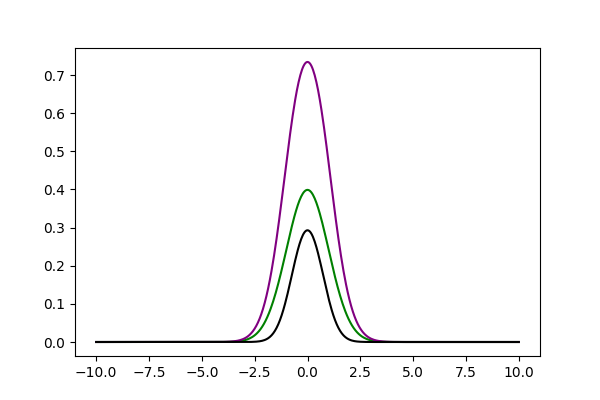

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

@widgets.interact(u=(-10, 10, 0.5), r=(0, 5, 0.1), m=(0, 100, 0.5))
def update(u=0, r=1, m=2):
    # """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    
    centre = np.array([u])
    res = np.array([r])
    p = gaussian(k[k.shape[0] // 2, :, 1, np.newaxis], centre, res)
    
    ax.plot(k[k.shape[0] // 2, :, 1], p, 'green')
    ax.plot(k[k.shape[0] // 2, :, 1], metz(p, m), 'purple')
    ax.plot(k[k.shape[0] // 2, :, 1], metz(p, m) * p, 'black')